# CapStone Project


In [ ]:
'''


Please run the external_user_extraction.ipynb before running the main_code.ipynb in order to get the necessary 
files needed to run the code below.


'''

## Problem Statement

Analyzing news headline using Natual Language Processing (NLP) from various notable publishers and understanding of the underlying <font color=red>sentiment of headlines</font> and <font color=red>predicting it's popularity from social media</font>. 


## Executive Summary 

The United States itself has numerous news publishers such as "New York Times", "Washington Post" and "ABC News". And it is no surprised many of these news publishers will be posting similar articles on their webpage and social media platform. However, each article are written by writers of different views therefore, the article will carry different sentiment. And with different views and sentiments it would also signifies the difference in popularity of the article.

Thus, the purpose of my model is to gather the number of shares on respective publishers social media platform and categorise them accordingly to their popularity. And the model would predict the popularity of the headline based on features such as sentiment and vector positioning of words.

The model would be useful for marketing strategy by gaining an understanding of readers preference based on article sentiment and keywords and provide insight for writers and editors on the ideal format of their articles. And provide additional assistance in putting the right title into the most effective social media platform so as to get the best readers reception by targetting the correct audience.

## Contents:
- [Importing & Preprocessing](#Importing-&-Preprocessing)
- [EDA](#EDA)
- [Train Word2Vec model](#Train-Word2Vec-model-based-on-Google-corpus)
- [Dimensionality Reduction: t-SNE](#Dimensionality-Reduction:-t-SNE)
- [t-SNE for Document Vectors](#t-SNE-for-Document-Vectors)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Word2Vec Prediction Method](#Word2Vec-Prediction-Method)
- [TFIDF Prediction Method](#TFIDF-Prediction-Method)
- [Evaluation Summary](#Evaluation-Summary)
- [Conclusion & Recommendation](#Conclusion-&-Recommendation)

In [1]:
#Import library

import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import xgboost as xgb


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.graph_objects as go

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer

import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from adjustText import adjust_text






/Users/Wilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing & Preprocessing

Importing of the main DataFrame known as <font color=blue>"News_Final.csv"</font>.

In [2]:
df = pd.read_csv('News_Final.csv', index_col=0)

In [3]:
df.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
IDLink,,,,,,,,,,
99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


### Removing of NaN values

In [4]:
df.isnull().sum()

Title                  0
Headline              15
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

In [5]:
df.dropna(subset=['Headline','Source'], axis=0, inplace=True)

In [6]:
df.isnull().sum()

Title                0
Headline             0
Source               0
Topic                0
PublishDate          0
SentimentTitle       0
SentimentHeadline    0
Facebook             0
GooglePlus           0
LinkedIn             0
dtype: int64

### Preprocessing Headline and Titles

Preprocessing of headline and titles, removing stop words and non-alphabetic words before using it for modelling and EDA.

In [7]:
def preprocessing(text):
    
    # Tokenize the string into words
    tokens = word_tokenize(text)
    
    # Remove non-alphabetic tokens, such as punctuation
    words = [word.lower() for word in tokens if word.isalpha()]
    
    # Filter stopwords
    stop_words = set(stopwords.words('english'))
    
    words = [word for word in words if not word in stop_words]
    
    return(" ".join(words))

### Clean Headline 

In [8]:
clean_headline = []

for headline in df['Headline']:
    clean_headline.append(preprocessing(headline))

### Clean Title

In [9]:
clean_title = []

for title in df['Title']:
    clean_title.append(preprocessing(title))

## EDA

### Top 20 unigrams (Headline)

Provide more insights on the top 20 single word used in headline. 

In [10]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer()
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_headline, 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1 = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df1.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

obama 30772
economy 26076
microsoft 24697
president 23232
quot 16016
barack 13268
said 9736
new 9454
economic 9087
year 6102
first 5164
one 5075
palestine 4812
windows 4779
growth 4729
world 4194
last 4155
washington 4075
us 4039
state 3984


In [11]:
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 bigrams (Headline)

Provide more insights on the top 20 bigrams words used in headline. 

In [12]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_headline, 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2 = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df2.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

barack obama 13166
president barack 11199
president obama 7365
white house 2788
obama administration 2288
obama said 1647
global economy 1441
us president 1360
economic growth 1351
prime minister 1344
donald trump 1247
united states 1191
last year 1144
economy grew 1061
supreme court 1030
per cent 1006
hillary clinton 936
european union 889
xbox one 830
washington ap 825


In [13]:
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 trigrams (Headline)

Provide more insights on the top 20 trigrams words used in headline. 

In [14]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(3, 3))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_headline, 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df3 = df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df3.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

president barack obama 11153
us president barack 1179
barack obama said 747
ap president barack 727
washington ap president 508
washington president barack 438
state union address 414
first lady michelle 412
gross domestic product 405
lady michelle obama 395
ceo satya nadella 355
microsoft nasdaq msft 335
white house said 323
international monetary fund 304
economy grew percent 294
final state union 291
cnn president barack 274
leave european union 269
barack obama says 261
president obama said 252


In [15]:
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 unigrams (Title)

Provide more insights on the top 20 single word used in title. 

In [16]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer()
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_title, 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4 = df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df4.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

obama 27646
economy 26432
microsoft 20497
palestine 3924
us 3735
new 3672
says 3514
president 3072
economic 2928
windows 2733
china 2700
global 2188
trump 2061
growth 1933
palestinian 1588
world 1499
state 1398
could 1344
one 1271
israel 1268


In [17]:
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 bigrams (Title) 

Provide more insights on the top 20 bigrams words used in title. 

In [18]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_title, 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df5 = df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df5.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

president obama 2069
us economy 1310
global economy 1271
barack obama 1184
obama says 860
obama administration 818
china economy 755
white house 751
supreme court 744
microsoft surface 609
xbox one 598
michelle obama 578
donald trump 519
uk economy 501
surface pro 458
economic growth 457
world economy 438
hillary clinton 390
obama visit 382
sharing economy 375


In [19]:
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

### Top 20 trigrams (Title)

Provide more insights on the top 20 trigrams word used in title. 

In [20]:
def get_top_n_words(text, n):
    
    vec = CountVectorizer(ngram_range=(3, 3))
    bag_of_words = vec.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) #Sum of words appearance throughout the rows
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_title, 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df6 = df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
df6.iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

microsoft surface pro 258
president barack obama 154
obama supreme court 118
supreme court nominee 118
ceo satya nadella 109
microsoft surface book 109
microsoft ceo satya 106
microsoft corporation msft 102
obama gun control 82
obama state union 76
final state union 74
microsoft lumia xl 70
market economy status 69
state union address 69
us economy grew 66
obama white house 65
economy grows percent 65
low oil prices 64
fastest growing economy 63
garland supreme court 61


In [21]:
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

Overall throughout the insights provided above between headline & title we noticed there were lots of common words associated with Obama, Microsoft, Global Economy and Palestinian. And this is no surprised as the data was extracted mostly during the Obama election campaign and many issues such as the global economy and the Palestinian affairs were widely disscussed. Microsoft were also a hot topic due to their new product released of the surface pro. 

### Words Comparison (Headline & Title unigrams)

To identify common single word between Headline and Title.

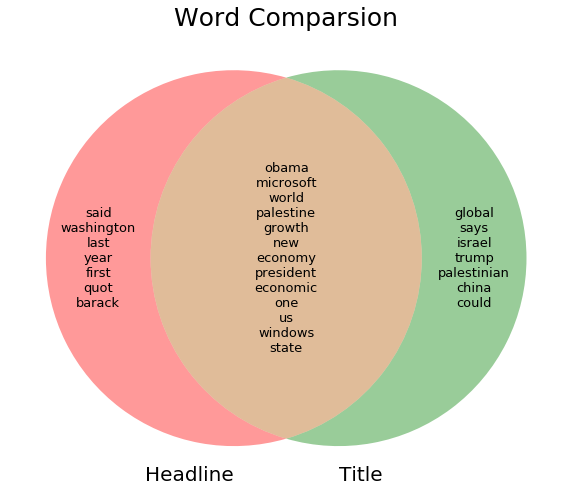

In [46]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df1['ReviewText'][:20])
set_b = set(df4['ReviewText'][:20])

venn = venn2([set_a,set_b],set_labels=['Headline','Title'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)
venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)

### Words Comparison (Headline & Title bigrams)

To identify common bigrams word between Headline and Title.

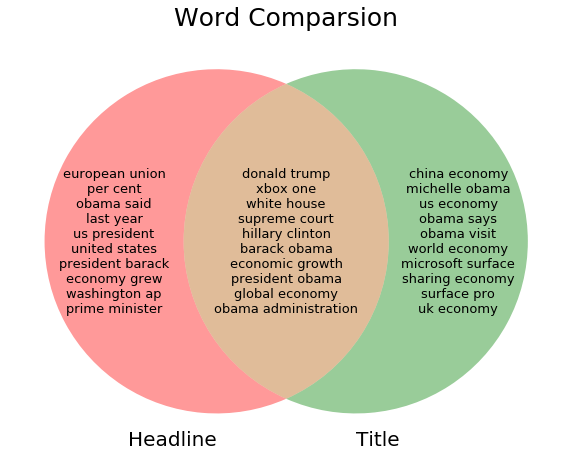

In [47]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df2['ReviewText'][:20])
set_b = set(df5['ReviewText'][:20])

venn = venn2([set_a,set_b],set_labels=['Headline','Title'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)
venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)

### Words Comparison (Headline & Title trigrams)

To identify common trigrams word between Headline and Title.

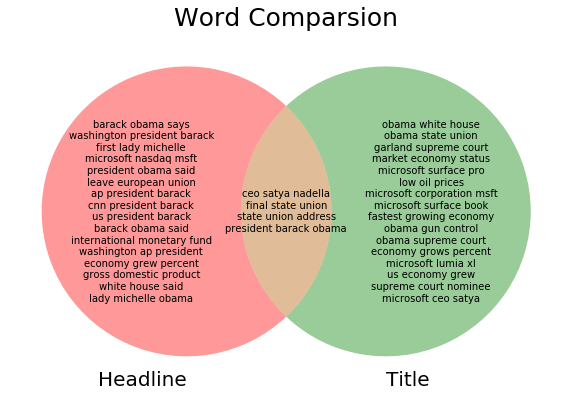

In [48]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df3['ReviewText'][:20])
set_b = set(df6['ReviewText'][:20])

venn = venn2([set_a,set_b],set_labels=['Headline','Title'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('100').set_size(10)
venn.get_label_by_id('110').set_size(10)
venn.get_label_by_id('010').set_size(10)
venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)

## Train Word2Vec model based on Google corpus

In relativity, I'd decided to use Google News model which was trained on about 100 billion words as my Word2Vec model. So the model will generate 300-dimensional word vectors and each word that passed through the model will create a vector. However, if the word is not within the model vocabulary no vector will be created for the particular word. 

In [187]:
# Load Word2Vec model (trained on an enormous Google corpus)

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

In [188]:
model.vector_size

300

In [189]:
# Test out the model dictionary 

word_economy = model['economy']

#First 20 components

word_economy[:20]

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

### Create vector model for headline and title


In [190]:
#Tokenise Headline
cleaned_headline_token = ' '.join(clean_headline)
cleaned_headline_token = word_tokenize(cleaned_headline_token) 


In [191]:
#Tokenise Title
cleaned_title_token = ' '.join(clean_title)
cleaned_title_token = word_tokenize(cleaned_title_token)

### Headline Vector list

The code below will filter the list of vectors to include only those that Word2Vec has a vector for it. 

In [192]:
#Headline Vector list
headline_vector = [model[word] for word in cleaned_headline_token if word in model.vocab]

headline_vector_word = [word for word in cleaned_headline_token if word in model.vocab]

headline_zip = zip(headline_vector_word, headline_vector)

headline_vec_dict = dict(headline_zip)
df_headline = pd.DataFrame.from_dict(headline_vec_dict, orient='index')
df_headline.to_csv('df_headline.csv',index=False)
df_headline.shape

(30744, 300)

In [193]:
df_headline.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477
arlington,-0.006653,0.023926,0.141602,0.160156,0.052490,0.113281,-0.125000,-0.138672,-0.136719,0.023071,...,0.130859,0.104004,0.064453,0.068848,-0.069336,-0.137695,-0.000572,-0.125977,-0.086914,0.112793
national,-0.135742,0.175781,0.117188,0.078613,0.052490,-0.238281,0.092773,-0.083984,0.061523,-0.062500,...,0.034180,-0.039551,0.034424,-0.075195,0.006775,-0.110840,0.069336,-0.068359,0.032471,-0.009338


### Title Vector list

In [194]:
#Title vector list 
title_vector = [model[word] for word in cleaned_title_token if word in model.vocab]

title_vector_word = [word for word in cleaned_title_token if word in model.vocab]

title_zip = zip(title_vector_word, title_vector)

title_vec_dict = dict(title_zip)
df_title = pd.DataFrame.from_dict(title_vec_dict, orient='index')
df_title.to_csv('df_title.csv',index=False)
df_title.shape

(21805, 300)

In [195]:
df_title.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477
arlington,-0.006653,0.023926,0.141602,0.160156,0.052490,0.113281,-0.125000,-0.138672,-0.136719,0.023071,...,0.130859,0.104004,0.064453,0.068848,-0.069336,-0.137695,-0.000572,-0.125977,-0.086914,0.112793
national,-0.135742,0.175781,0.117188,0.078613,0.052490,-0.238281,0.092773,-0.083984,0.061523,-0.062500,...,0.034180,-0.039551,0.034424,-0.075195,0.006775,-0.110840,0.069336,-0.068359,0.032471,-0.009338


## Dimensionality Reduction: t-SNE

In order to visualize those word vectors and to spot for any patterns <font color=blue>Dimensionality Reduction with t-SNE</font> is used here. The t-SNE aids in transforming higher dimensional vector into a lower dimensional vector for ease of visualisation. In this case, the word vectors were transformed into 2D vector. There were several values tested for the parameters of perplexity and learning rate but it always produces similar shape each time. Thus, the ideal value of perplexity was input into the model and learning rate is based on the default value of 200. 

### t-SNE Headline

In [197]:
#!pip install adjustText

In [198]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 5)

# Use only 500 rows to shorten processing time
tsne_df_headline = tsne.fit_transform(df_headline[:500])

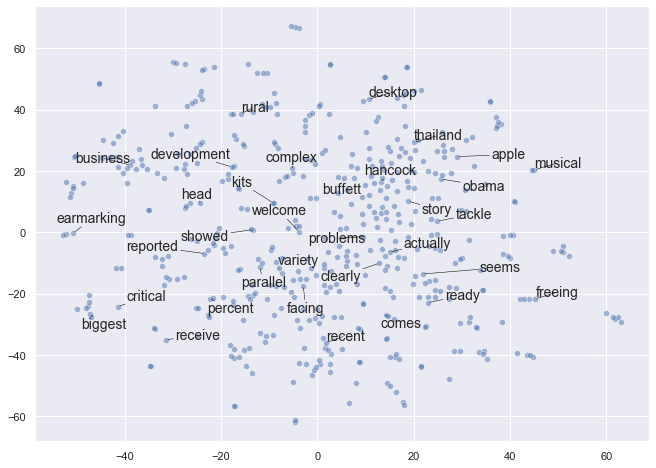

In [199]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
sns.scatterplot(tsne_df_headline[:, 0], tsne_df_headline[:, 1], alpha = 0.5)

#initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 500, 15))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df_headline[word, 0], tsne_df_headline[word, 1], df_headline.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

### t-SNE Title

In [200]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 10)

# Use only 500 rows to shorten processing time
tsne_df_title = tsne.fit_transform(df_title[:500])

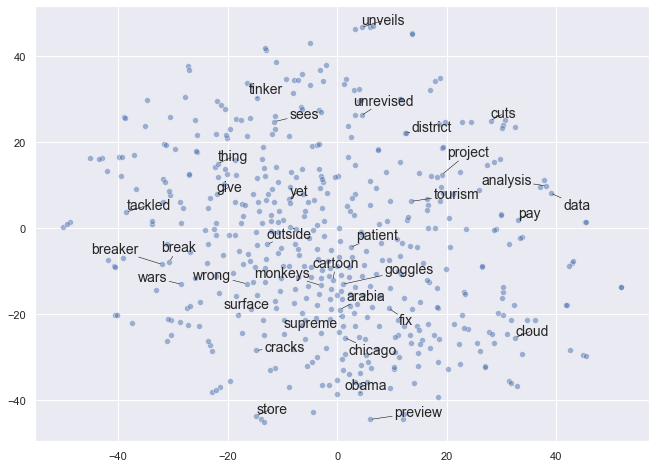

In [201]:
sns.set()

fig, ax = plt.subplots(figsize = (11, 8))
sns.scatterplot(tsne_df_title[:, 0], tsne_df_title[:, 1], alpha = 0.5)

#initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 500, 15))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df_title[word, 0], tsne_df_title[word, 1], df_title.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

The two t-SNE diagrams from headline and title did not show much pattern when single word vector are input into it. However, bearing in mind that t-SNE is not deterministic the density of clusters and distances between each clusters are not always meaningful. It is plainly a exploratory tool rather than a decisive indicator of similarity

### Averaging Word Embeddings

In [202]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [203]:
headline_list = [headline for headline in df['Headline']]

In [204]:
title_list = [title for title in df['Title']]

In [205]:
# Preprocess the corpus (HEADLINE)
corpus = [preprocess(headline) for headline in headline_list]

# Remove docs that don't include any words in W2V's vocab
corpus, headline_list = filter_docs(corpus, headline_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, headline_list = filter_docs(corpus, headline_list, lambda doc: (len(doc) != 0))

11 docs removed
0 docs removed


In [206]:
# Preprocess the corpus (TITLE)
corpus_title = [preprocess(title) for title in title_list]

# Remove docs that don't include any words in W2V's vocab
corpus_title, title_list = filter_docs(corpus_title, title_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus_title, title_list = filter_docs(corpus_title, title_list, lambda doc: (len(doc) != 0))

36 docs removed
0 docs removed


In [207]:
# Initialize an array for the size of the corpus (HEADLINE)
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

In [208]:
# Initialize an array for the size of the corpus (TITLE)
x_title = []
for doc in corpus_title: # append the vector for each document
    x_title.append(document_vector(model, doc))
    
X_title = np.array(x_title) # list to array

## t-SNE for Document Vectors

### t-SNE Headline

In [209]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 20)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:500])

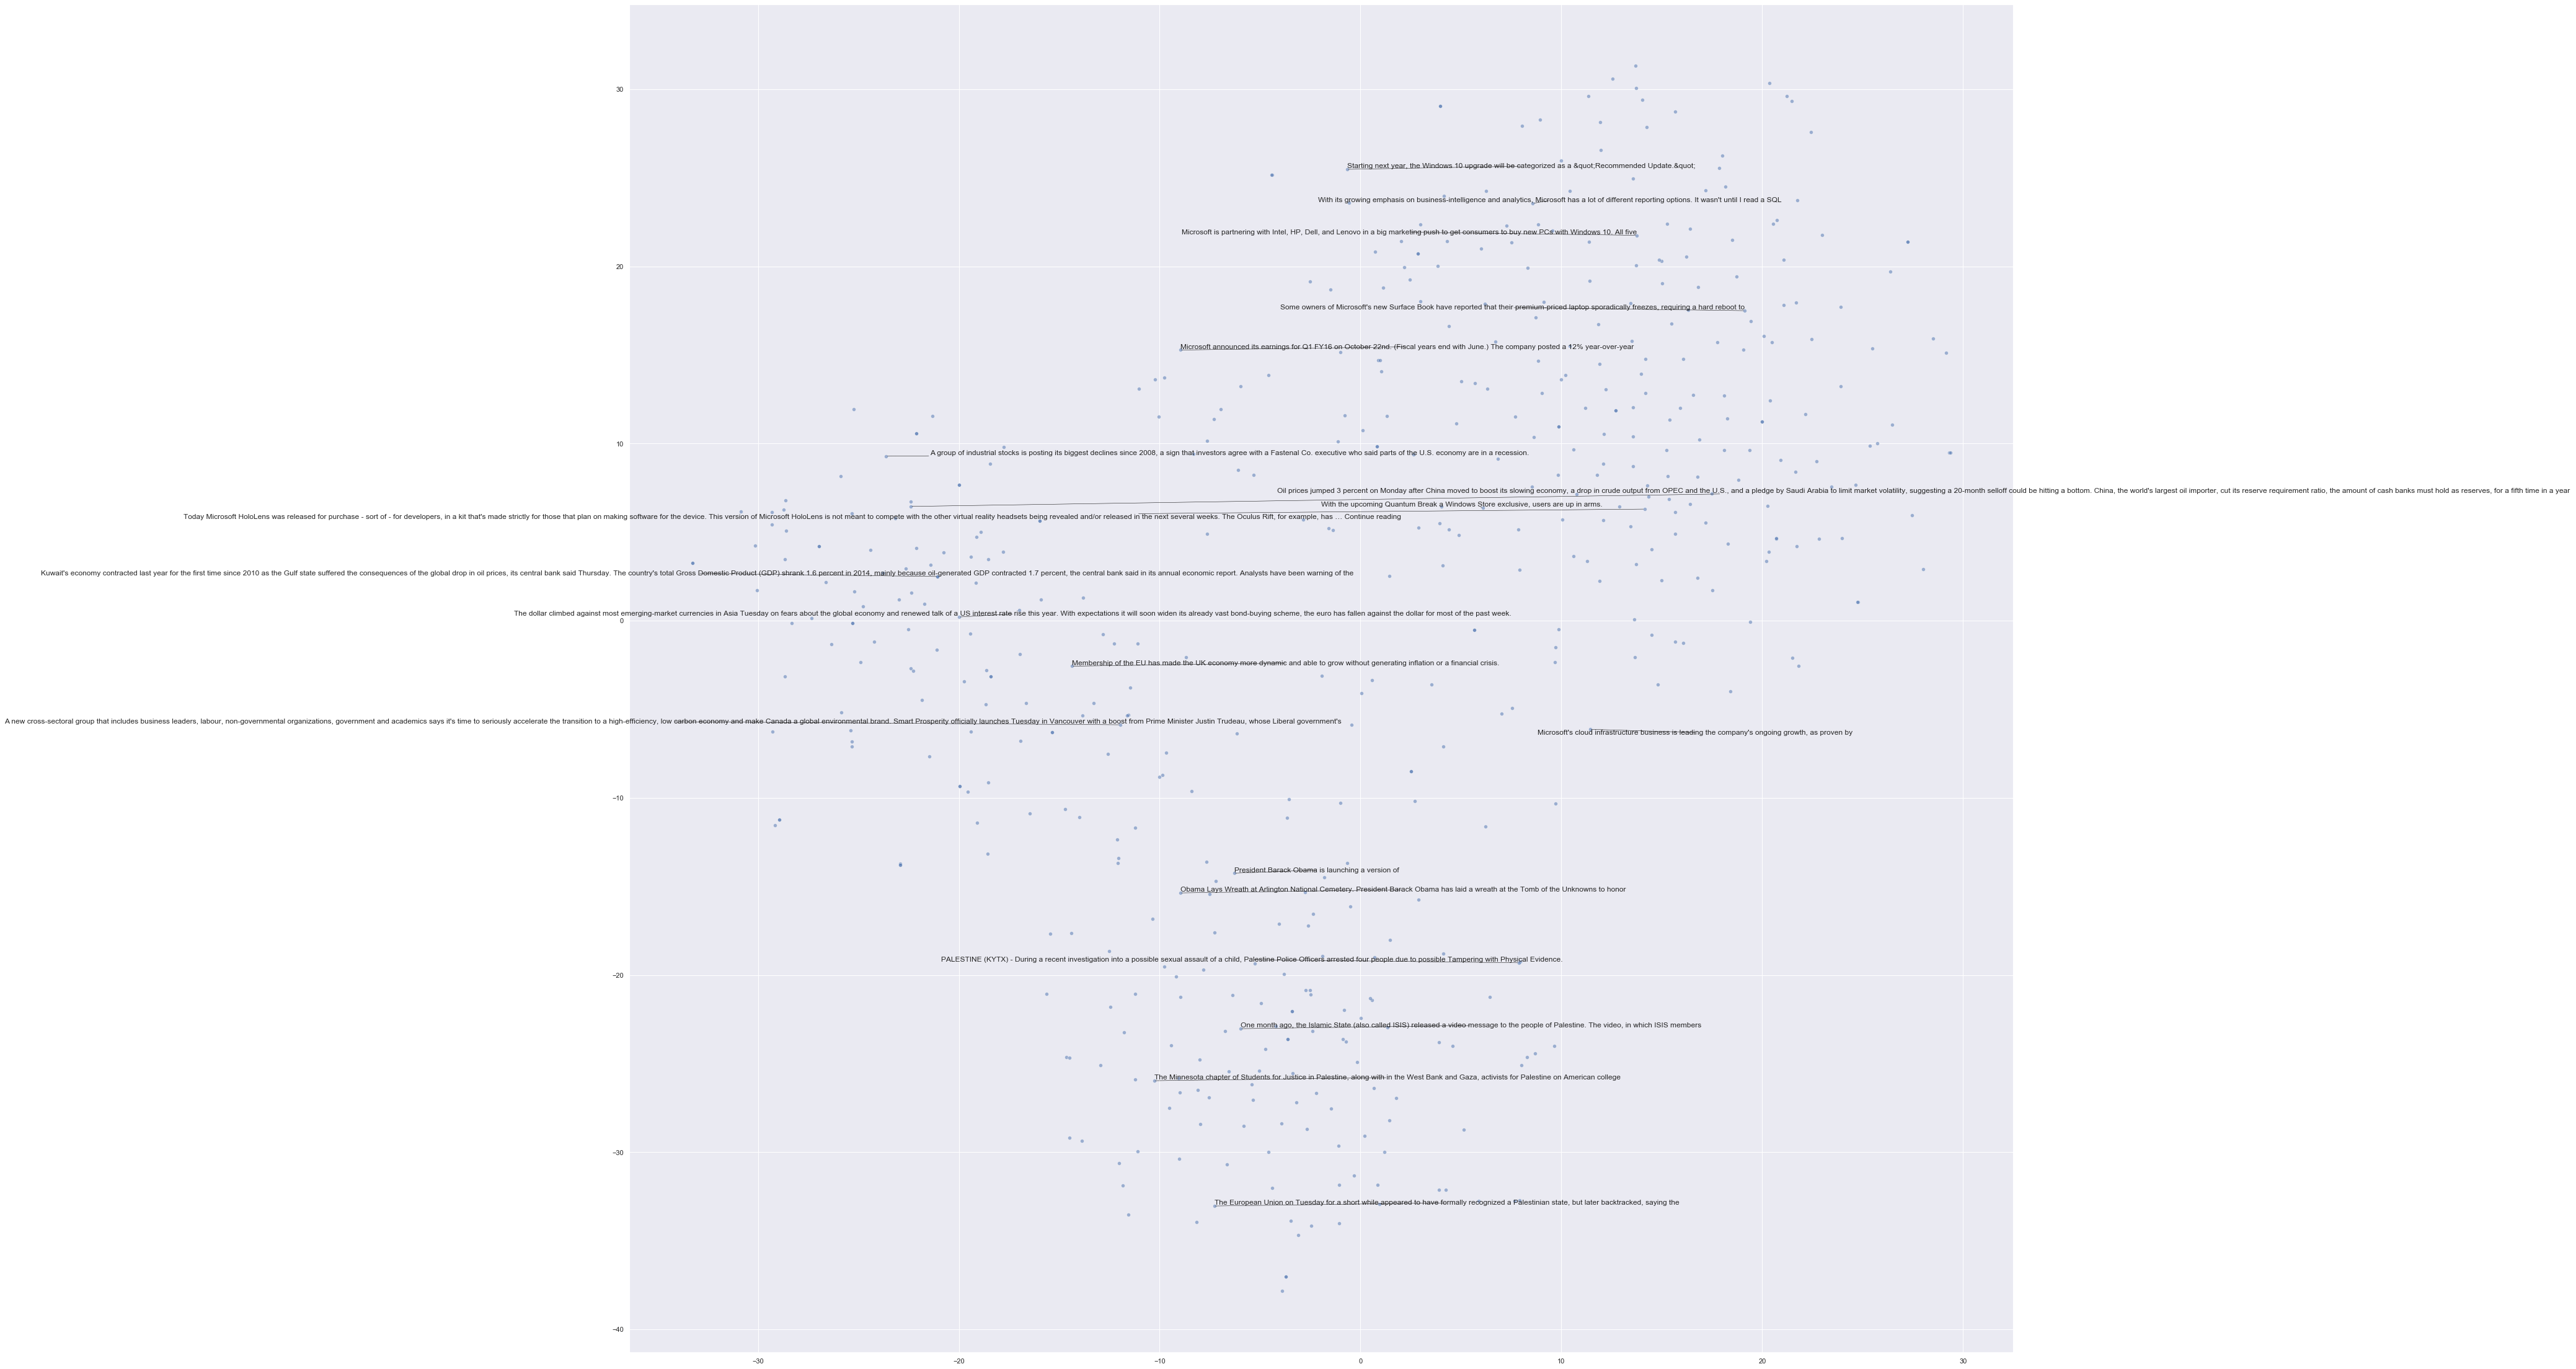

In [210]:
fig, ax = plt.subplots(figsize = (40, 40))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
headline_to_plot = list(np.arange(0, 500, 25)) # plots every 40th title in first 400 titles

# Append words to list
for headline in headline_to_plot:
    texts.append(plt.text(tsne_df[headline, 0], tsne_df[headline, 1], headline_list[headline], fontsize = 12))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.6, force_text = 0.6, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5)) 

plt.savefig('headline.png', bbox_inches='tight')
plt.show()


###  t-SNE Title

In [211]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 10)

# Use only 400 rows to shorten processing time
tsne_df_title = tsne.fit_transform(X_title[:500])

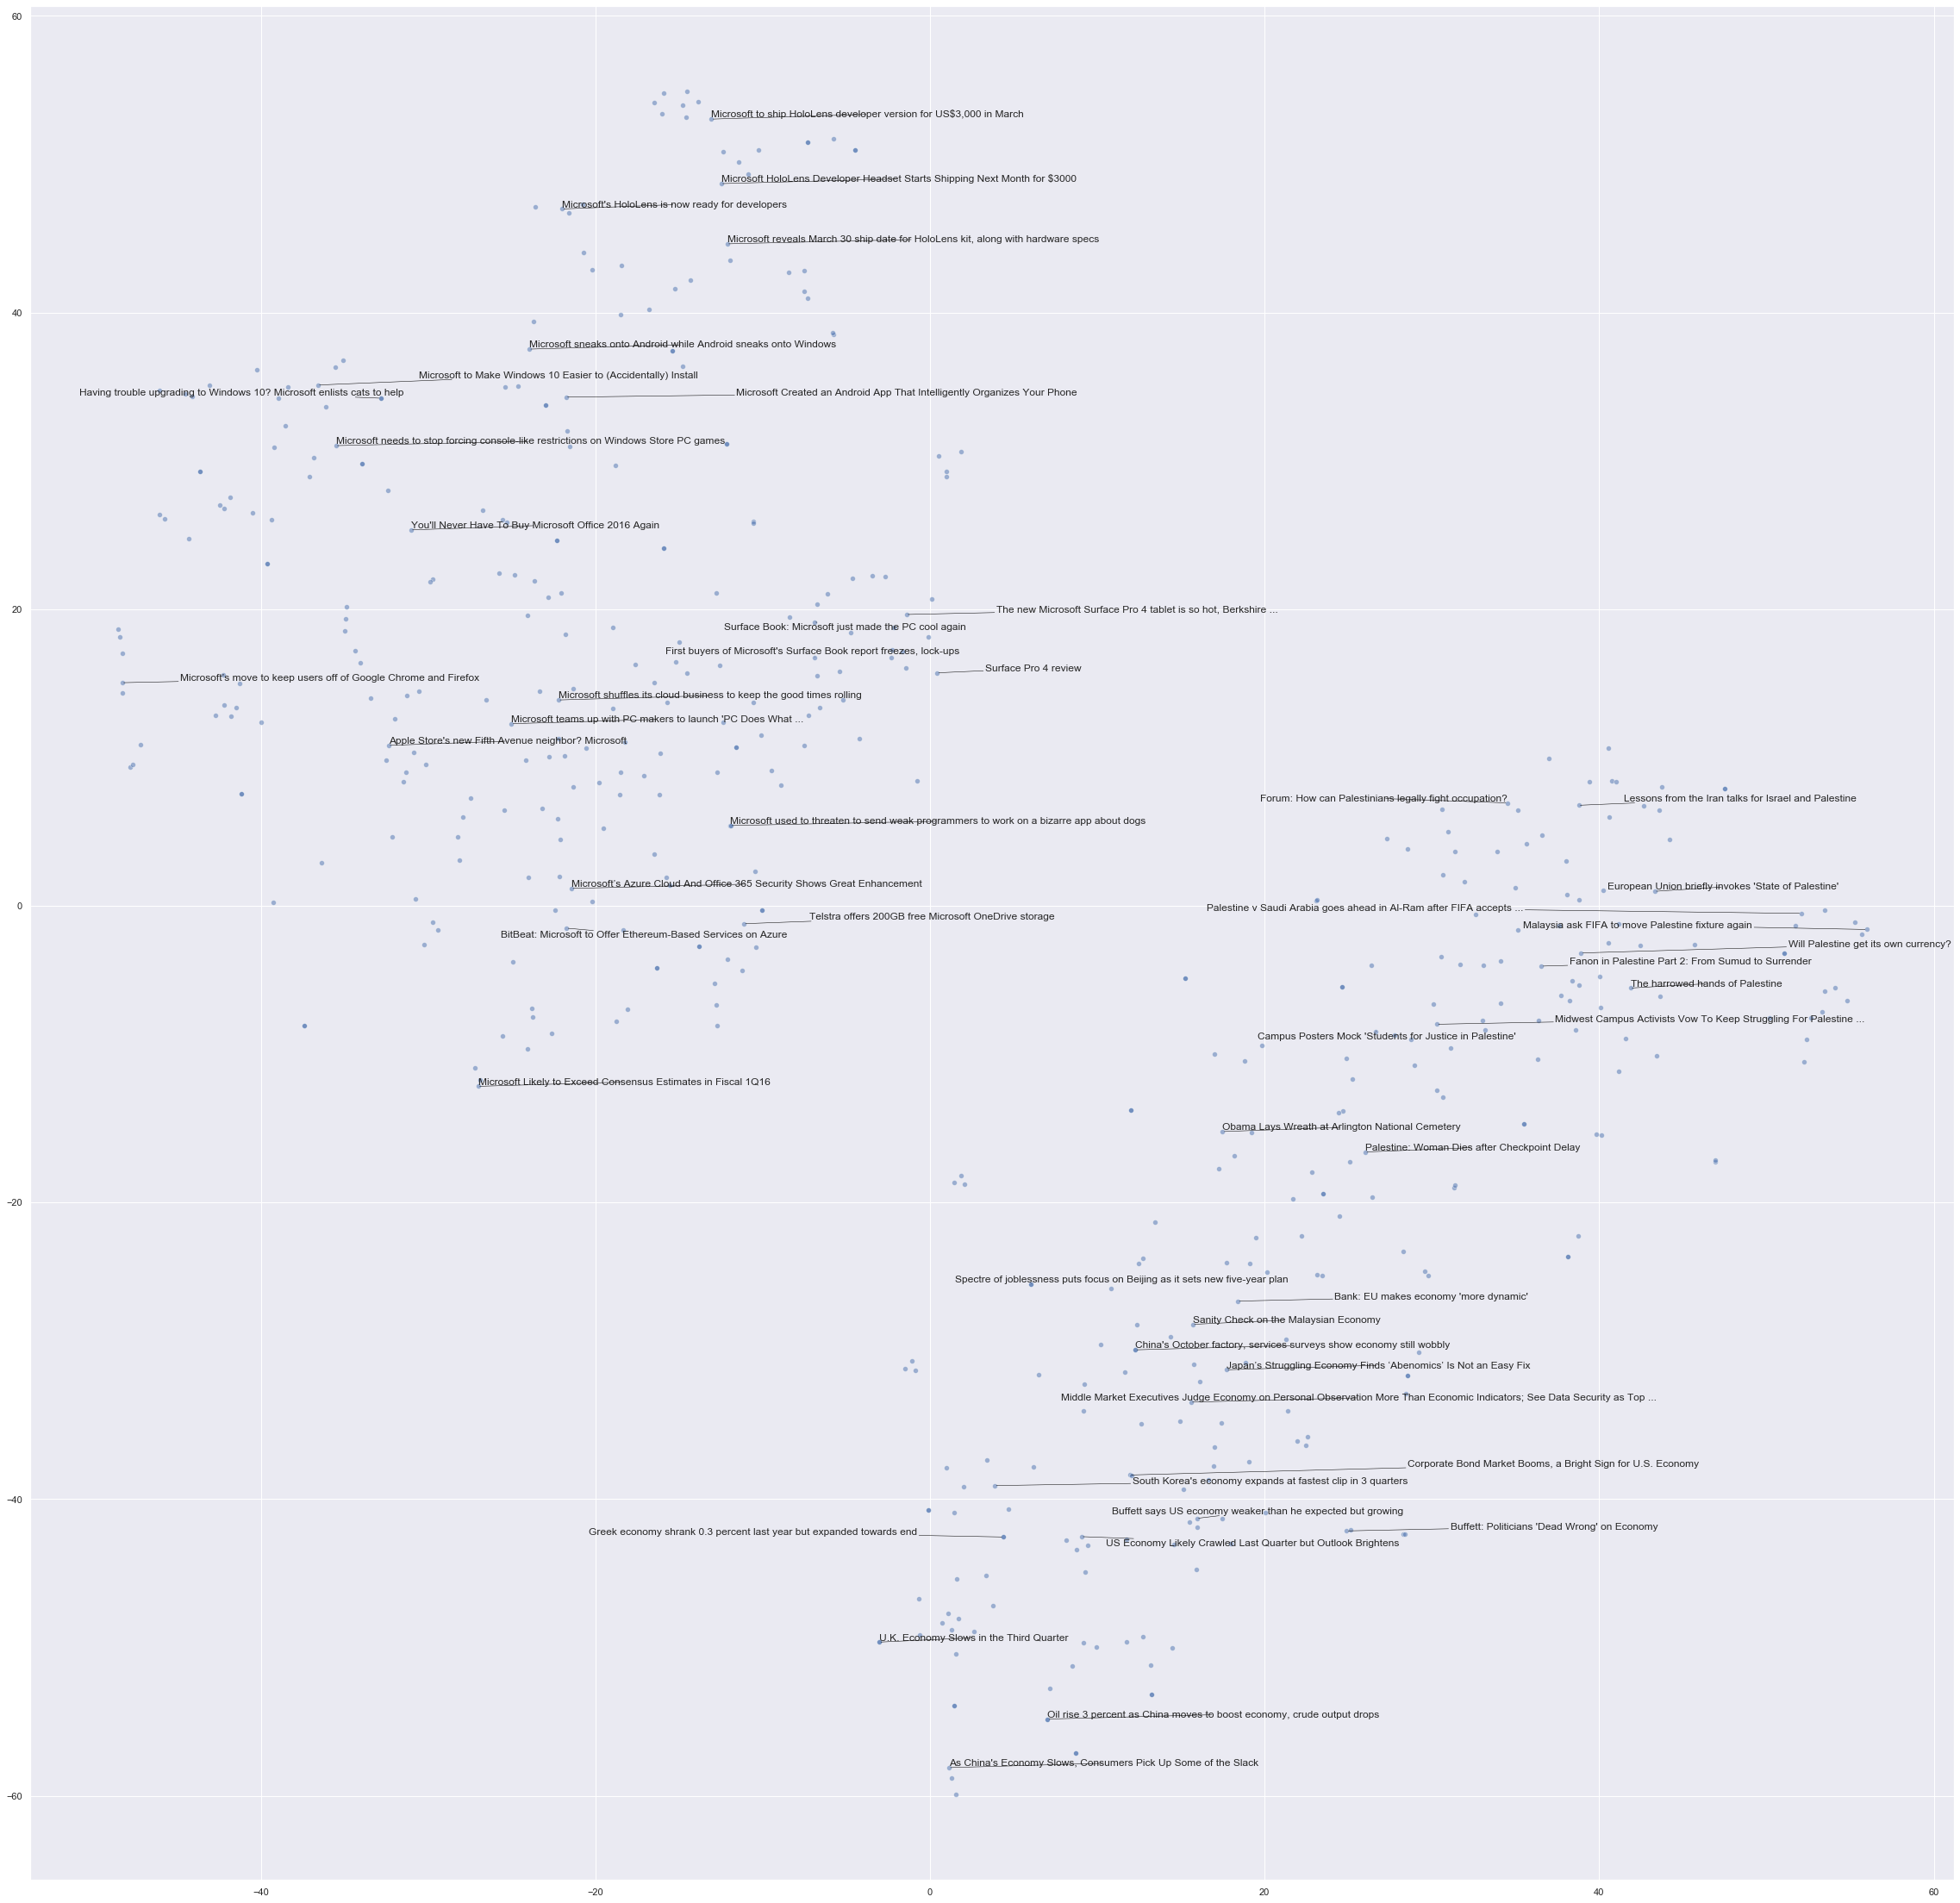

In [212]:
fig, ax = plt.subplots(figsize = (40, 40))
sns.scatterplot(tsne_df_title[:, 0], tsne_df_title[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
title_to_plot = list(np.arange(0, 500, 10)) # plots every 40th title in first 400 titles

# Append words to list
for title in title_to_plot:
    texts.append(plt.text(tsne_df_title[title, 0], tsne_df_title[title, 1], title_list[title], fontsize = 12))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.6, force_text = 0.6, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.savefig('title.png', bbox_inches='tight')
plt.show()



As for the whole sentence vector model, the headline and title t-SNE diagrams show a huge difference in pattern as compared to the single word vector model. There is a clear distinction of clustering between topics such as Microsoft and Economy. It could also mean that t-SNE would be more effective in giving meaningful informations when whole sentence vector are input into the model as compared to single word input model.  

## Sentiment Analysis

In [213]:
# Null measurements for popularity are represented in this data as -1
# Drop all the rows where the article popularities are unknown (this is only about 11% of the data)
main_data = df.drop(df[(df.Facebook == -1) | 
                    (df.GooglePlus == -1) | 
                    (df.LinkedIn == -1)].index)

main_data.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
IDLink,,,,,,,,,,
311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0
252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0,0,0
227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0,0,0
307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0,0,0
207.0,IDC predicts the emergence of ‘DX economy’,KUCHING: The global digital economy is about t...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1,0,0


In [214]:
# Get the list of top 12 sources by number of articles
source_names = list(main_data['Source'].value_counts()[:12].index)
source_colors = list(sns.husl_palette(12, h=.5))

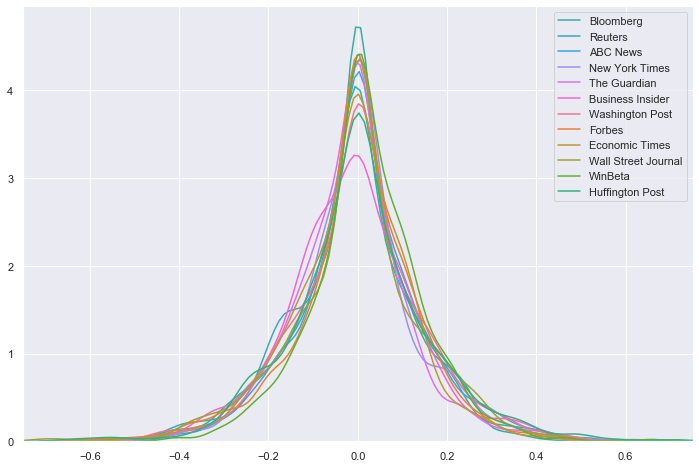

In [215]:
fig, ax = plt.subplots(figsize=(12, 8))

for source, color in zip(source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, hist=False, label=source, color=color)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

The sentiment distribution are relative identical and it does not tell much story of the individual publisher article in terms of their sentiment.

In [216]:
# Group by Source, then get descriptive statistics for title sentiment
source_info = main_data.groupby('Source')['SentimentTitle'].describe()
# Recall that `source_names` contains the top 12 sources
# We'll also sort by highest standard deviation
source_info.loc[source_names].sort_values('std', ascending=False)[['std', 'min', 'max']]

,std,min,max
Source,,,
Huffington Post,0.158071,-0.644314,0.711512
Wall Street Journal,0.152442,-0.711512,0.617945
Business Insider,0.148298,-0.557338,0.573742
Washington Post,0.146626,-0.530340,0.504280
Reuters,0.145920,-0.585573,0.676516
New York Times,0.141851,-0.555912,0.662913
ABC News,0.141676,-0.424931,0.795495
Forbes,0.138622,-0.618718,0.455132
Bloomberg,0.138444,-0.632712,0.612372


When the sentiment values are converted to descriptive statistics a clearer picture is formed. Huffington Post has the highest standard deviation and the largest range and the Wall Street Journal has one of the most negative sentiment article as compared to the ABC News which appear to has the most positive sentiment article.

### Popularity VS Sentiment 

In [217]:
#Drop all rows where popularity are unknown

df = df.drop(df[(df.Facebook == -1)|
               (df.GooglePlus == -1)|
               (df.LinkedIn == -1)].index)



In [218]:
df.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
IDLink,,,,,,,,,,
311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0
252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0,0,0
227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0,0,0
307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0,0,0
207.0,IDC predicts the emergence of ‘DX economy’,KUCHING: The global digital economy is about t...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1,0,0


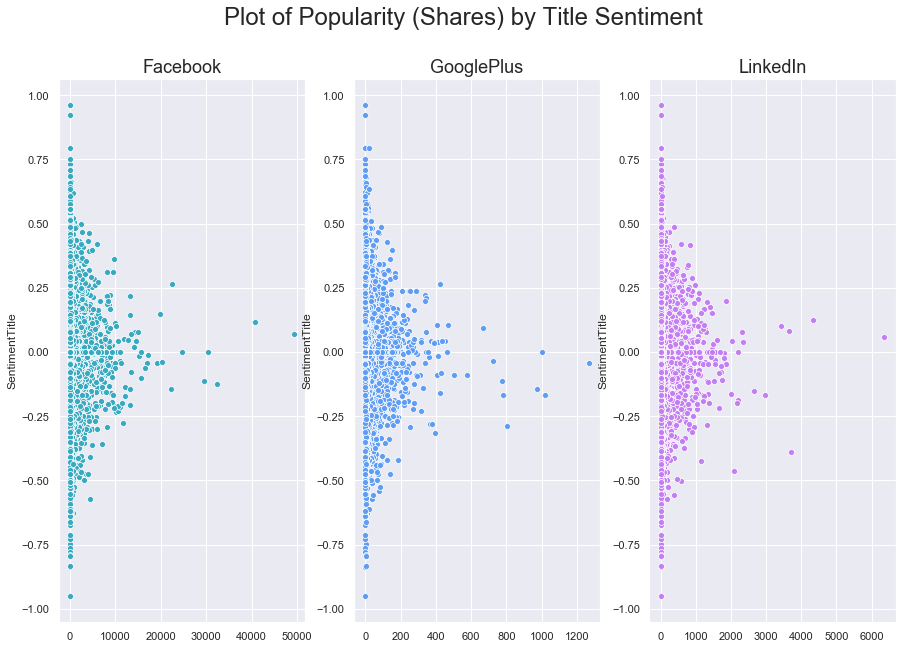

In [219]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = df[platform], y = df['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

From the diagram above, not much relationship get be drawn between the sentiment values and popularity as measured by number of shares.

### Preprocessing and Data Reduction using PCA 

As the data contains over 300-dimensional word vectors, it will not be possible to run it on the current computer. So dimension reduction using PCA was used to reduce the 300-dimensional word vectors into 15-dimensional word vectors. It will fasten the process of running the model.

In [220]:
pca = PCA(n_components=15, random_state=10)

# as a reminder, x is the array with our 300-dimensional vectors
reduced_vec = pca.fit_transform(x_title)
df_w_vectors = pd.DataFrame(reduced_vec)

df_w_vectors['Title'] = title_list
# Use pd.concat to match original titles with their vectors
main_w_vectors = pd.concat((df_w_vectors, df), axis=1)

# Get rid of vectors that couldn't be matched with the main_df
main_w_vectors.dropna(axis=0, inplace=True)

In [226]:
# Drop all non-numeric, non-dummy columns, for feeding into the models
cols_to_drop = ['Title','Headline', 'PublishDate', 'Source'] 

data_only_df = pd.get_dummies(main_w_vectors, columns = ['Topic']).drop(columns=cols_to_drop)

In [228]:
data_only_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Topic_economy,Topic_microsoft,Topic_obama,Topic_palestine
1.0,-0.339783,-0.114798,0.439808,0.092815,0.083435,-0.059410,0.242902,-0.149947,-0.064081,0.098129,...,-0.053671,0.087462,-0.093750,13.0,1.0,2.0,1,0,0,0
2.0,-0.890622,-0.499274,0.419695,0.092215,-0.010560,0.005727,0.174918,-0.074450,-0.054017,-0.143568,...,-0.017818,0.037689,-0.177667,42.0,0.0,0.0,1,0,0,0
3.0,0.125260,-0.053164,0.419849,0.295896,0.213602,0.594641,-0.241662,0.305890,-0.201147,0.269397,...,-0.011524,-0.094491,-0.060817,98.0,23.0,0.0,1,0,0,0
4.0,-0.205993,-0.107823,0.458011,0.291801,-0.063792,0.104200,-0.157423,-0.092683,0.133599,0.250045,...,0.170005,0.077340,-0.079204,7.0,1.0,10.0,1,0,0,0
5.0,0.355611,-0.508685,-0.175883,-0.119617,-0.116571,0.207280,0.063383,-0.097508,-0.088298,-0.169016,...,-0.023936,-0.065219,-0.145935,34.0,0.0,0.0,1,0,0,0


## Word2Vec Prediction Method

Overall there would be two methods in predicting the popularity of Titles in which I would sum up the results of both methods. The first method would be the use of Word2Vec model, using the word vector to accurately predict the popularity of Titles. And the second method would be the use of TFIDF model to give weightage to words based on their frequencies appearing in the text.

The codes below will first start off with the Word2Vec model followed by the TFIDF model.

### Extracting features and target (Facebook)

In this project I would be using 'Facebook' as the target label as it is more commonly used among the populations as compared to the other social media platform listed. 

In [229]:
#FACEBOOK as target

X = data_only_df.drop(['Facebook', 'GooglePlus', 'LinkedIn'], axis=1)
y = data_only_df['Facebook']

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [231]:
# StandardScaler

ss = StandardScaler()
ss_X_train = ss.fit_transform(X_train)
ss_X_test = ss.transform(X_test)

In [232]:
# Using describe to identify the range of Facebook likes count. 
data_only_df['Facebook'].describe()

count    72035.000000
mean       120.906184
std        662.323229
min          0.000000
25%          1.000000
50%          7.000000
75%         38.000000
max      49211.000000
Name: Facebook, dtype: float64

In [233]:
""" 
A function to create dummies for faceboook popularity and split them into 3 categories.

-1:Not Popular
0:Neutral
1:Popular


"""

def dummy(facebook_popularity):
    if facebook_popularity <= 1:
        return -1
    elif facebook_popularity <= 7:
        return 0
    else:
        return 1
    

In [234]:
#Create new dummies column in data_only_df

data_only_df['fb_dumb'] = data_only_df['Facebook'].apply(dummy)
data_only_df[['Facebook', 'fb_dumb']].head()


,Facebook,fb_dumb
1.0,13.0,1
2.0,42.0,1
3.0,98.0,1
4.0,7.0,0
5.0,34.0,1


In [235]:
data_only_df['fb_dumb'].value_counts() #75586

 1    34744
-1    21276
 0    16015
Name: fb_dumb, dtype: int64

### Compensating for imbalanced class

As seen from above there is a imbalanced between the classes that were created therefore, resampling the minority classes with replacement was initiated to balance the three classes. To have a overall better accuracy in the overall model. 

In [236]:
#Classifying of classes based on minority and majority class

minority_class_0 = data_only_df[data_only_df['fb_dumb']==0]
minority_class_1 = data_only_df[data_only_df['fb_dumb']==-1]
majority_class = data_only_df[data_only_df['fb_dumb']==1]


#Resamples minority class with replacement
minority_upsampled_0 = resample(minority_class_0,
                             replace=True,
                             n_samples=majority_class.shape[0],
                             random_state=42)

minority_upsampled_1 = resample(minority_class_1,
                               replace=True,
                               n_samples=majority_class.shape[0],
                               random_state=42)

#Combined majority class with the minorities class
rebalanced = pd.concat([minority_upsampled_0, majority_class])
rebalanced_2 = pd.concat([minority_upsampled_1, rebalanced])

rebalanced_2.fb_dumb.value_counts()


-1    34744
 1    34744
 0    34744
Name: fb_dumb, dtype: int64

In [237]:
df_balanced = shuffle(rebalanced_2, random_state=42)
df_balanced.reset_index(drop=True, inplace=True)


df_balanced.head()

,0,1,2,3,4,5,6,7,8,9,...,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Topic_economy,Topic_microsoft,Topic_obama,Topic_palestine,fb_dumb
0,0.345011,-0.340016,-0.294952,-0.104024,0.064221,-0.164958,0.009190,-0.167624,0.040922,-0.003023,...,0.000000,0.068041,1.0,0.0,0.0,1,0,0,0,-1
1,-0.088187,0.364385,-0.034386,-0.202082,-0.169314,-0.085263,0.112971,-0.022963,-0.110898,0.049378,...,-0.177171,-0.271322,7.0,1.0,3.0,1,0,0,0,0
2,-0.089135,-0.196480,-0.092418,-0.115722,0.194566,0.045654,-0.098671,-0.036088,0.003035,-0.034348,...,-0.088939,0.134830,0.0,0.0,0.0,1,0,0,0,-1
3,-0.189741,0.576068,-0.054796,-0.219169,-0.272397,0.166188,0.055251,0.005877,0.021637,-0.208552,...,0.039528,0.026064,0.0,0.0,0.0,0,1,0,0,-1
4,-0.350493,-0.119374,0.027947,0.125591,0.051804,-0.013088,0.289946,-0.161624,-0.151912,0.025476,...,0.110243,0.014118,29.0,1.0,33.0,1,0,0,0,1


### XGBClassifier Basemodel 

All the models used will start off with a basemodel before GridSearch is done so as to compare the changes in the results once optimal hyper-parameters are input into the model. 

In [23]:
# Feature selection and target label

X = df_balanced.drop(['Facebook', 'GooglePlus', 'LinkedIn','fb_dumb'], axis=1)

y = df_balanced['fb_dumb']

In [24]:
# Train, test and split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# StandardScaler

ss = StandardScaler()
ss_X_train = ss.fit_transform(X_train)
ss_X_test = ss.transform(X_test)

In [7]:
xgclass = xgb.XGBClassifier()

In [8]:
xgclass = xgclass.fit(ss_X_train, y_train)

In [9]:
# Predict

y_pred = xgclass.predict(ss_X_test)

In [14]:
metrics.confusion_matrix(y_test, y_pred)

array([[5002, 4310, 1795],
       [3970, 5503, 1933],
       [2818, 3296, 5096]])

In [15]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.42      0.45      0.44     11107
           0       0.42      0.48      0.45     11406
           1       0.58      0.45      0.51     11210

    accuracy                           0.46     33723
   macro avg       0.47      0.46      0.46     33723
weighted avg       0.47      0.46      0.46     33723



### XGBClassifier GridSearch

In [18]:
params = {
    'n_estimators' : [200, 500, 1000],
    'max_depth' : [3, 9, 15, 20],
    'learning_rate' : [0.1, 0.01, 0.001],
    'subsample' : [0.6, 0.7, 0.8],
    'colsample_bytree' : [0.6, 0.7, 0.8]    
}

In [ ]:
xgclass_grid = GridSearchCV(xgclass,
                            param_grid=params,
                            cv = 2,
                            verbose = 1 ,
                            n_jobs=-1
                            )

xgclass_grid.fit(ss_X_train, y_train)



Fitting 2 folds for each of 324 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 63.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 184.0min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 298.2min finished


In [20]:
print(xgclass_grid.best_score_)
print(xgclass_grid.best_params_)

0.6379325682768437
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.7}


### XGBClassifier with Best Params

In [22]:
params = {
    'n_estimators' : 500,
    'max_depth' : 20,
    'learning_rate' : 0.1,
    'subsample' : 0.7,
    'colsample_bytree' : 0.8    
}

In [23]:
xgclass_best = xgb.XGBClassifier(random_state=2, **params)

xgclass_best.fit(ss_X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=2, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.7)

In [25]:
y_pred = xgclass_best.predict(ss_X_test)

In [28]:
metrics.confusion_matrix(y_test, y_pred)

array([[8745,  684, 1678],
       [ 704, 9568, 1134],
       [2176, 1387, 7647]])

In [29]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.75      0.79      0.77     11107
           0       0.82      0.84      0.83     11406
           1       0.73      0.68      0.71     11210

    accuracy                           0.77     33723
   macro avg       0.77      0.77      0.77     33723
weighted avg       0.77      0.77      0.77     33723



### RandomForest GridSearch

In [52]:
params = {
    'n_estimators' : [200, 500],
    'max_depth' : [15, 20],
    'min_samples_split': np.linspace(0.1, 0.5, 5),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5),
    'max_features' : [5, 10, 15]
}

In [53]:
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    verbose=1,
    cv= 2,
    n_jobs=-1
    
)

rf_grid.fit(ss_X_train, y_train)

Fitting 2 folds for each of 300 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 10.1min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [54]:
model_rf = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_

In [55]:
# predict y
y_pred = pd.DataFrame(model_rf.predict_proba(ss_X_test), columns=['-1','0','1'])

In [56]:
# print results
print("Best parameters:", rf_best_params)
print("Best score:", rf_grid.best_score_)

Best parameters: {'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'n_estimators': 500}
Best score: 0.4456136337641542


### RandomForest with Best Params 

In [42]:
params = {'max_depth': 20, 
          'max_features': 5, 
          'min_samples_leaf': 0.1, 
          'min_samples_split': 0.2, 
          'n_estimators': 500}

In [43]:
rf_best = RandomForestClassifier(random_state=2, **params)

rf_best.fit(ss_X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [44]:
y_pred = rf_best.predict(ss_X_test)

In [47]:
metrics.confusion_matrix(y_test, y_pred)

array([[6485, 2758, 1864],
       [6057, 3358, 1991],
       [3896, 2194, 5120]])

In [48]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.39      0.58      0.47     11107
           0       0.40      0.29      0.34     11406
           1       0.57      0.46      0.51     11210

    accuracy                           0.44     33723
   macro avg       0.46      0.45      0.44     33723
weighted avg       0.46      0.44      0.44     33723



### KNN Basemodel 

In [243]:
knn = KNeighborsClassifier()

In [244]:
knn.fit(ss_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [245]:
y_pred = knn.predict(ss_X_test)

In [247]:
metrics.confusion_matrix(y_test, y_pred)

array([[6312, 2410, 1647],
       [2871, 6157, 1389],
       [3601, 3024, 3859]])

In [248]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.49      0.61      0.55     10369
           0       0.53      0.59      0.56     10417
           1       0.56      0.37      0.44     10484

    accuracy                           0.52     31270
   macro avg       0.53      0.52      0.52     31270
weighted avg       0.53      0.52      0.52     31270



### KNN GridSearch 

In [257]:
params = { 'n_neighbors':[2,5,10,20],
          }

In [258]:
knn_grid = GridSearchCV(estimator=KNeighborsClassifier(),
                       param_grid=params,
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

knn_grid.fit(ss_X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  2.9min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': [2, 5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [259]:
# print results
print("Best parameters:", knn_grid.best_params_)
print("Best score:", knn_grid.best_score_)

Best parameters: {'n_neighbors': 2}
Best score: 0.5565636906883035


In [260]:
y_pred = knn_grid.predict(ss_X_test)

In [261]:
# Confusion Matrix
metrics.confusion_matrix(y_test, y_pred)

array([[8652, 1116,  601],
       [2062, 7931,  424],
       [4205, 3172, 3107]])

In [262]:
# F1 score
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.58      0.83      0.68     10369
           0       0.65      0.76      0.70     10417
           1       0.75      0.30      0.43     10484

    accuracy                           0.63     31270
   macro avg       0.66      0.63      0.60     31270
weighted avg       0.66      0.63      0.60     31270



### Support Vector Machine BaseModel

In [268]:
svm = SVC()

In [269]:
svm.fit(ss_X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [270]:
y_pred = svm.predict(ss_X_test)

In [271]:
# Confusion Matrix
metrics.confusion_matrix(y_test, y_pred)

array([[5238, 3554, 1577],
       [3245, 5643, 1529],
       [2948, 3179, 4357]])

In [272]:
# F1 score
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.46      0.51      0.48     10369
           0       0.46      0.54      0.50     10417
           1       0.58      0.42      0.49     10484

    accuracy                           0.49     31270
   macro avg       0.50      0.49      0.49     31270
weighted avg       0.50      0.49      0.49     31270



### Support Vector Machine GridSearch 

In [273]:
svm = SVC(gamma='scale')

In [274]:
params = {'kernel': ['rbf','linear','poly'],
        'C': [1,1.2,1.4,1.6,1.8,2]
         }

In [275]:
svm_grid = GridSearchCV(
    svm,
    param_grid=params,
    cv=3,
    n_jobs=-1,
)

svm_grid.fit(ss_X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 1.2, 1.4, 1.6, 1.8, 2],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [276]:
print(svm_grid.best_score_)
print(svm_grid.best_params_)

0.48903538828431237
{'C': 2, 'kernel': 'rbf'}


In [277]:
y_pred = svm_grid.predict(ss_X_test)

In [278]:
# Confusion Matrix
metrics.confusion_matrix(y_test, y_pred)

array([[5501, 3220, 1648],
       [3046, 5775, 1596],
       [2932, 2972, 4580]])

In [279]:
# F1 score
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.48      0.53      0.50     10369
           0       0.48      0.55      0.52     10417
           1       0.59      0.44      0.50     10484

    accuracy                           0.51     31270
   macro avg       0.52      0.51      0.51     31270
weighted avg       0.52      0.51      0.51     31270



## TFIDF Prediction Method

This would be the second method used to predict Titles popularity on Facebook using TFIDF. In which word frequencies in text replaces word vector in the features selection.  

### Data Pre-processing

In [33]:
#Read CSV file

df_tfidf = pd.read_csv('tfidf_data.csv',index_col=0)
df_tfidf.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,clean_headline
IDLink,,,,,,,,,,,
99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,obama lays wreath arlington national cemetery ...
10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,tim haywood investment director head fixed inc...
18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,nouriel roubini nyu professor chairman roubini...
27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,finland economy expanded marginally three mont...
27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,tourism public spending continued boost econom...


In [34]:
#Drop all rows where popularity are unknown

df_tfidf = df_tfidf.drop(df_tfidf[(df_tfidf.Facebook == -1)|
               (df_tfidf.GooglePlus == -1)|
               (df_tfidf.LinkedIn == -1)].index)


In [35]:
""" 
A function to create dummies for faceboook popularity and split them into 3 categories.

-1:Not Popular
0:Neutral
1:Popular


"""
def dummy(facebook_popularity):
    if facebook_popularity <= 1:
        return -1
    elif facebook_popularity <= 7:
        return 0
    else:
        return 1
    

In [36]:
#Create new dummies column in data_only_df

df_tfidf['fb_dumb'] = df_tfidf['Facebook'].apply(dummy)
df_tfidf[['Facebook', 'fb_dumb']].head()


,Facebook,fb_dumb
IDLink,,
311.0,0,-1
252.0,0,-1
227.0,0,-1
307.0,0,-1
207.0,1,-1


In [37]:
df_tfidf['fb_dumb'].value_counts()

 1    40974
-1    23048
 0    17384
Name: fb_dumb, dtype: int64

### Compensating for imbalanced class

In [38]:
#Classifying of classes based on minority and majority class

minority_class_0 = df_tfidf[df_tfidf['fb_dumb']==0]
minority_class_1 = df_tfidf[df_tfidf['fb_dumb']==-1]
majority_class = df_tfidf[df_tfidf['fb_dumb']==1]


#Resamples minority class with replacement
minority_upsampled_0 = resample(minority_class_0,
                             replace=True,
                             n_samples=majority_class.shape[0],
                             random_state=42)

minority_upsampled_1 = resample(minority_class_1,
                               replace=True,
                               n_samples=majority_class.shape[0],
                               random_state=42)

#Combined majority class with the minorities class
rebalanced_3 = pd.concat([minority_upsampled_0, majority_class])
rebalanced_4 = pd.concat([minority_upsampled_1, rebalanced_3])

rebalanced_4.fb_dumb.value_counts()



-1    40974
 1    40974
 0    40974
Name: fb_dumb, dtype: int64

In [39]:
rebalanced_4.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,clean_headline,fb_dumb
IDLink,,,,,,,,,,,,
39187.0,US economy seen growing 0.7% in first quarter:...,NEW YORK: The US economy is growing at a 0.7 p...,Economic Times,economy,2016-04-01 17:10:12,0.114583,-0.011104,1,0,0,new york us economy growing per cent pace firs...,-1
2919.0,Jinping: China committed to overhaul to keep e...,"MANILA, Philippines — Chinese President Xi Jin...",The Medina County Gazette,economy,2015-11-18 08:06:00,-0.041667,-0.097361,0,0,0,manila philippines chinese president xi jinpin...,-1
69383.0,"Swaraj heads to Israel, Palestine in mid-Jan",External Affairs Minister Sushma Swaraj will t...,Chandigarh Tribune,palestine,2015-12-29 21:04:47,0.000000,-0.104257,1,0,0,external affairs minister sushma swaraj travel...,-1
53555.0,Mugabe's chief secretary: Zim's economy is rec...,"HARARE """""" President Robert Mugabe's chief sec...",Eyewitness News,economy,2016-06-01 16:00:10,0.188982,-0.009559,0,0,0,harare president robert mugabe chief secretary...,-1
27436.0,Eurozone economic sentiment downbeat for February,The latest surveys of businesses and individua...,euronews,economy,2016-02-26 15:40:25,-0.102062,0.038179,0,0,1,latest surveys businesses individuals european...,-1


### MultinomialNB Basemodel

In [40]:
#Feature Selection

X = rebalanced_4['clean_headline'].astype('U')
y = rebalanced_4['fb_dumb']

#Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [11]:
#Model 1

tfidf = TfidfVectorizer()
nb = MultinomialNB()

In [12]:
tfidf_X_train = tfidf.fit_transform(X_train)

tfidf_X_test = tfidf.transform(X_test)

In [140]:
#Fit model

nb.fit(tfidf_X_train,y_train)

y_pred = nb.predict(tfidf_X_test)

In [142]:
#Confusion Matrix
metrics.confusion_matrix(y_test, y_pred)

array([[7477, 2273, 2542],
       [3067, 6549, 2676],
       [2455, 2693, 7145]])

In [143]:
#F1 score
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.58      0.61      0.59     12292
           0       0.57      0.53      0.55     12292
           1       0.58      0.58      0.58     12293

    accuracy                           0.57     36877
   macro avg       0.57      0.57      0.57     36877
weighted avg       0.57      0.57      0.57     36877



### MultinomialNB GridSearch

In [146]:
pipe = Pipeline([('tfidf', tfidf), ('nb', nb)])

In [167]:
params = {
        'tfidf__max_features': range(5000,6000,7000),
        'tfidf__max_df': np.arange(0.8,0.9,0.95),
        'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)]
        }

grid_model = GridSearchCV(
    pipe,
    params,
    cv=3,
    n_jobs=-1,
    verbose=100
)

grid_model.fit(X_train, y_train)



Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(86045,), dtype=object).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(86045,), dtype=int64).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(57362,), dtype=int64).
Pickling array (shape=(28683,), dtype=int64).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(86045,), dtype=object).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(86045,), dtype=int64).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(57363,), dtype=int64).
Pickling array (shape=(28682,), dtype=int64).
Pickling array (shape=(86045,), dtype=float64).
Pickling array (shape=(86045,), dtype=object).
Pickling array 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [168]:
print('best_score:', grid_model.best_score_)
print('best_params:', grid_model.best_params_)

best_score: 0.5042245336742402
best_params: {'tfidf__max_df': 0.8, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3)}


In [169]:
y_pred = grid_model.predict(X_test)



In [170]:
#Confusion Matrix
metrics.confusion_matrix(y_test, y_pred)

array([[5959, 3430, 2903],
       [3424, 5584, 3284],
       [2149, 3116, 7028]])

In [171]:
#F1 score
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.52      0.48      0.50     12292
           0       0.46      0.45      0.46     12292
           1       0.53      0.57      0.55     12293

    accuracy                           0.50     36877
   macro avg       0.50      0.50      0.50     36877
weighted avg       0.50      0.50      0.50     36877



### KNN Basemodel

In [13]:
knn = KNeighborsClassifier()

In [344]:
knn.fit(tfidf_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [345]:
y_pred = knn.predict(tfidf_X_test)

In [346]:
metrics.confusion_matrix(y_test, y_pred)

array([[8436, 2436, 1420],
       [3247, 7502, 1543],
       [3569, 3583, 5141]])

In [347]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.55      0.69      0.61     12292
           0       0.55      0.61      0.58     12292
           1       0.63      0.42      0.50     12293

    accuracy                           0.57     36877
   macro avg       0.58      0.57      0.57     36877
weighted avg       0.58      0.57      0.57     36877



### KNN GridSearch

In [14]:
pipe = Pipeline([('tfidf', tfidf), ('knn', knn)])


In [15]:
params = {
        'tfidf__max_features': range(5000,6000,7000),
        'tfidf__max_df': np.arange(0.8,0.9,0.95),
        'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)],
        'knn__n_neighbors': [2,5,7,10]
        }

In [17]:
knn_grid = GridSearchCV(pipe,
                       param_grid=params,
                       cv=3,
                       n_jobs=4,
                       verbose=10)

knn_grid.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done  33 out of  36 | elapsed:  6.8min remaining:   37.0s
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  7.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [18]:
print('Best params:', knn_grid.best_params_)
print('Best score:', knn_grid.best_score_)


Best params: {'knn__n_neighbors': 2, 'tfidf__max_df': 0.8, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3)}
Best score: 0.479353826486141


In [19]:
y_pred = knn_grid.predict(X_test)


In [20]:
metrics.confusion_matrix(y_test, y_pred)


array([[11707,   445,   140],
       [ 4897,  7270,   125],
       [ 9908,  1083,  1302]])

In [21]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.44      0.95      0.60     12292
           0       0.83      0.59      0.69     12292
           1       0.83      0.11      0.19     12293

    accuracy                           0.55     36877
   macro avg       0.70      0.55      0.49     36877
weighted avg       0.70      0.55      0.49     36877



### Support Vector Machine Basemodel

In [36]:
svm = SVC(gamma='scale')

In [39]:
svm.fit(tfidf_X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
y_pred = svm.predict(tfidf_X_test)

In [41]:
metrics.confusion_matrix(y_test, y_pred)

array([[9773,  937, 1582],
       [1142, 9592, 1558],
       [1738, 1612, 8943]])

In [42]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.80      0.78     12292
           0       0.79      0.78      0.79     12292
           1       0.74      0.73      0.73     12293

    accuracy                           0.77     36877
   macro avg       0.77      0.77      0.77     36877
weighted avg       0.77      0.77      0.77     36877



### Support Vector Machine GridSearch

In [27]:
svm = SVC(gamma='scale')

In [28]:
pipe = Pipeline([('tfidf',tfidf),('svm',svm)])

In [29]:
params = {
        'tfidf__max_features': range(5000,6000,7000),
        'tfidf__max_df': np.arange(0.8,0.9,0.95),
        'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)],
        'svm__kernel':['rbf','linear','poly'],
        'svm__C':[1,1.2,1.4,1.6,1.8,2]
        }

In [ ]:
svm_grid = GridSearchCV(pipe,
                       param_grid=params,
                       cv=2,
                       n_jobs=-1,
                       verbose=1)

svm_grid.fit(X_train,y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 80.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 306.7min finished


In [32]:
print('Best params:', svm_grid.best_params_)
print('Best score:', svm_grid.best_score_)

Best params: {'svm__C': 2, 'svm__kernel': 'poly', 'tfidf__max_df': 0.8, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Best score: 0.7012842117496658


In [33]:
y_pred = svm_grid.predict(X_test)

In [34]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 9744,   533,  2015],
       [  652,  9876,  1764],
       [  878,   609, 10806]])

In [35]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.79      0.83     12292
           0       0.90      0.80      0.85     12292
           1       0.74      0.88      0.80     12293

    accuracy                           0.83     36877
   macro avg       0.83      0.83      0.83     36877
weighted avg       0.83      0.83      0.83     36877



## Evaluation Summary

### Word2Vec Model 

**Word2Vec & XGBClassifier GridSearch** was the best performing Word2Vec model as it has one of the highest accuracy f1 score and lower type errors as compared to other deployed methods. 


### Data collected from Word2Vec model

|Model      |F1-score      |
|---------    |------    |
|**XGBClassifier Basemodel** |0.46    |
|**XGBClassifier GridSearch**        |**0.77**   |
|**RandomForest Bsemodel** |0.44  |
|**RandomForest GridSearch**    |0.51    |
|**KNN Basemodel**    |0.52    |
|**KNN GridSearch**  |0.63    |
|**SVM Basemodel**    |0.49    |
|**SVM GridSearch**    |0.51    |

**Accuracy:** XGBClassifier GridSearch provided the highest F1-score of **0.77**.  


### TFIDF Model 

**TFIDF & SVM GridSearch** was the best performing TFIDF model as it has one of the highest accuracy based on F1-score and lower type errors as compared to other deployed methods. 


### Data collected from TFIDF model

|Model      |F1-score      |
|---------    |------    |
|**MultinomialNB Basemodel** |0.57    |
|**MultinomialNB GridSearch**        |0.5   |
|**KNN Basemodel**    |0.57    |
|**KNN GridSearch**  |0.55    |
|**SVM Basemodel**    |0.77    |
|**SVM GridSearch**    |**0.83**    |

**Accuracy:** SVM GridSearch provided the highest F1-score of **0.83**.  

### Best Word2Vec & TFIDF model

|Model      |F1-score      |
|---------    |------    |
|**XGBClassifier GridSearch (Word2Vec)** |0.77    |
|**SVM GridSearch (TFIDF)**        |0.83   |

## Conclusion & Recommendation

In conclusion, SVM GridSearch (TFIDF) had a better accuracy result as compared to the XGBclassifier GridSearch (Word2Vec). This might be due to the fact that the features input were different for both models. As explained above, Word2Vec model transform words into word vector and using those vector dimensions we tried to predict the target label. From the t-SNE graph it can be clearly seen that individual word vector do not show any clear distinction of clustering or patterns. Thus, putting through those features into the model might not prove to be the most ideal.

As for the TFIDF method, it transforms individual words into frequencies of occurence from within the text and applies weightage to it. The accuracy did improve when TFIDF method was used, it might be due to the weightage that was applied into the model that helps to classify the important and unimportant words from within the text.

In the marketing aspect, lots of informations can be obtained from the EDA. Through observation of Fig 1.5, we can understand the reader demographics in each social media platform and do an AB testing on the article title by understanding what makes an article title so shareable or attractive to readers on different platforms. The comparison in key words used between popular titles in different social media platform can be use as reference for the test.

There are ways to improve on the model using Word2Vec which are also the limitation faced while running the model. The full word vector dimensions were not used in this project due to computation limitation from hardware. Therefore, using progressive loading method we can get a better overall accuracy by implementating platform like Spark which is highly efficient in running large data by distributing dataset into different nodes and computation are done on individual nodes. Or implementating cloud services by running the dataset on remote servers which have better hardware specification and supported functions library.
